In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import seaborn as sns 
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# EDA 

In [2]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df['train_test'] = 1
df_test['train_test'] = 0
all_data = pd.concat([df, df_test])

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [4]:
df_num = df[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = df[['Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

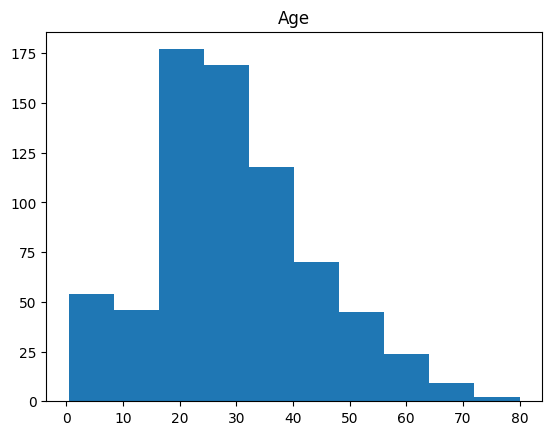

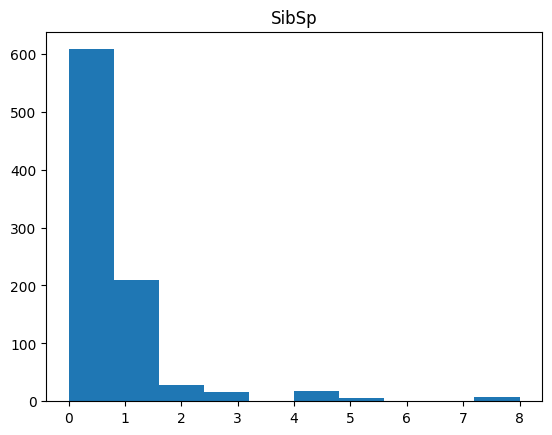

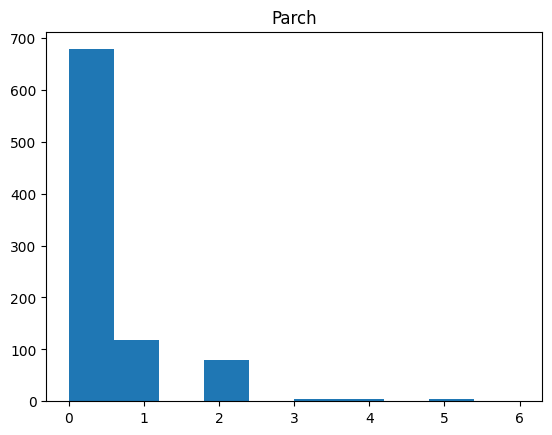

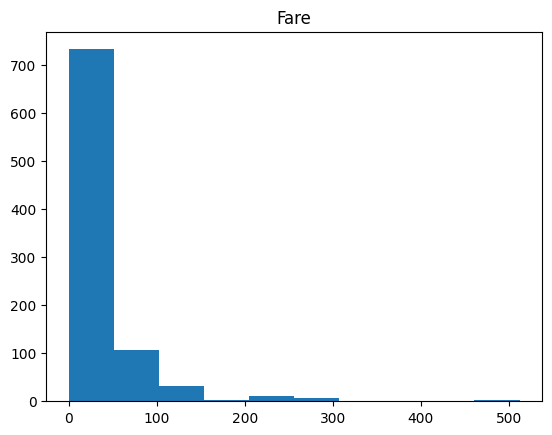

In [5]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()


In [6]:
print(df_num.corr())

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

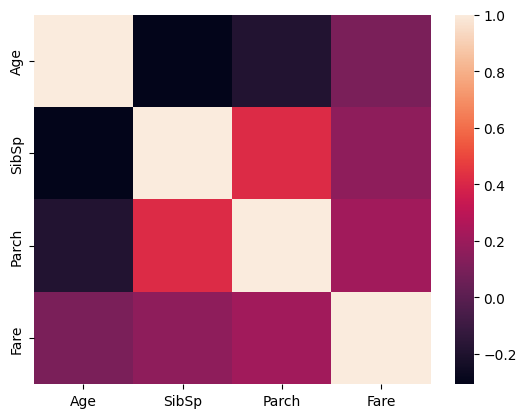

In [7]:
sns.heatmap(df_num.corr())

In [8]:
pd.pivot_table(df, index='Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


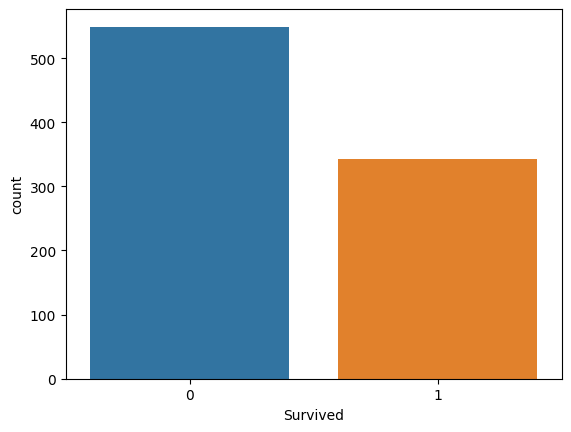

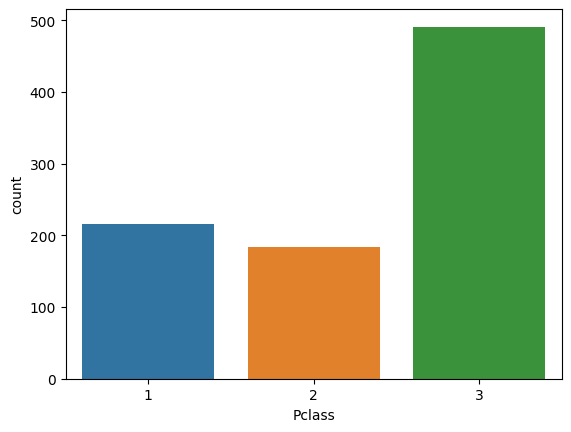

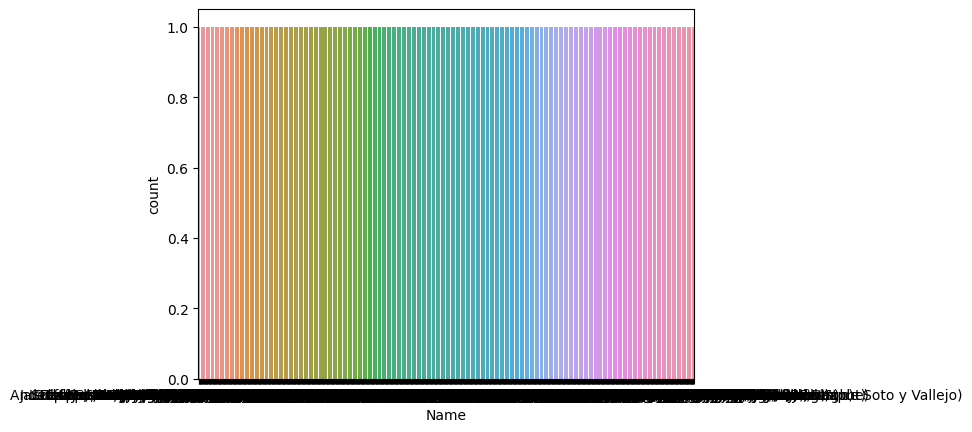

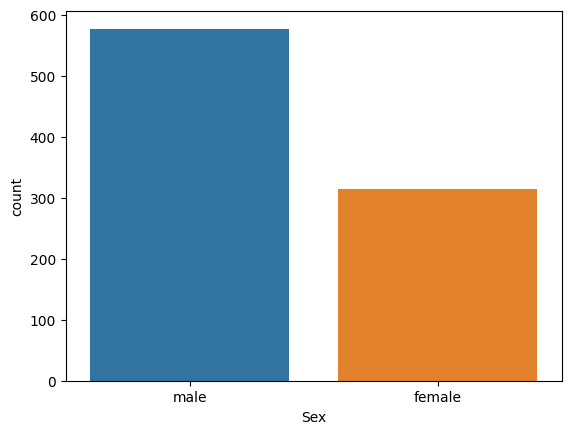

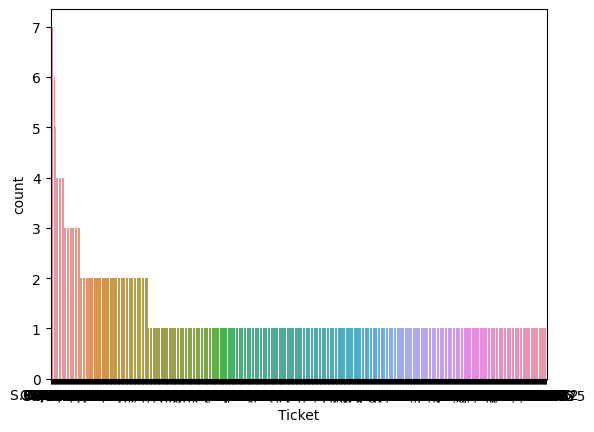

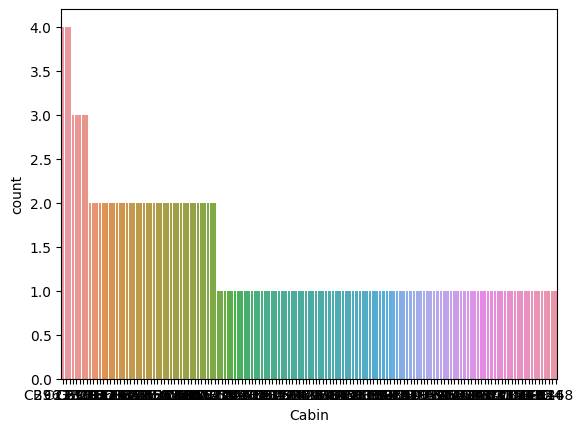

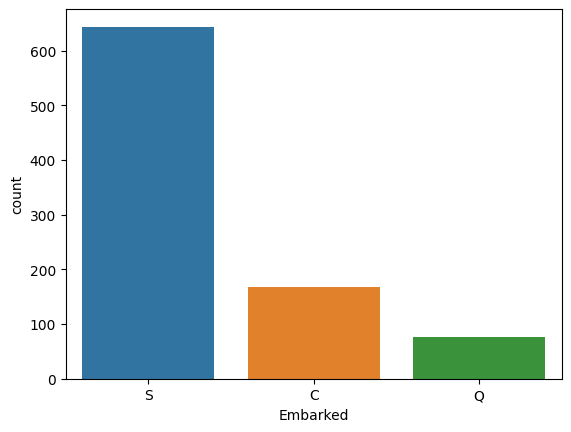

In [9]:
for i in df_cat.columns:
    sns.barplot(x = df_cat[i].value_counts().index, y = df_cat[i].value_counts())
    plt.show()

In [10]:
print(pd.pivot_table(df, index='Survived', columns = 'Pclass', values = 'Ticket', aggfunc='count'))
print()
print(pd.pivot_table(df, index='Survived', columns = 'Sex', values = 'Ticket', aggfunc='count'))
print()
print(pd.pivot_table(df, index='Survived', columns = 'Embarked', values = 'Ticket', aggfunc='count'))
print()

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217



# Feature Engineering

In [11]:
df['cabin_multiple'] = df.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
df['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [12]:
#feature engineering adding a cabin letter 
#creates categories bassed on the cabin letter (n is null) and treated as a separate category
df['cabin_adv'] = df.Cabin.apply(lambda x: str(x)[0])
df['cabin_adv']

0      n
1      C
2      n
3      C
4      n
      ..
886    n
887    B
888    n
889    C
890    n
Name: cabin_adv, Length: 891, dtype: object

In [13]:
#comparing survival rate by cabin assignment
pd.pivot_table(df, index='Survived', columns='cabin_adv', values='Name', aggfunc='count')

cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [14]:
#feature engineering adding a column for numerical tickets
#understand ticket values better 
df['numeric_ticket'] = df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
df['numeric_ticket'].value_counts()

numeric_ticket
1    661
0    230
Name: count, dtype: int64

In [15]:
pd.pivot_table(df, index='Survived', columns='numeric_ticket', values='Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [16]:
#explore the names proviced in the data set and find titles data that can be used as a variable
df.Name.head(50)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [17]:
#feature engineering adding a name title
df['name_title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['name_title'].value_counts()

name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [18]:
pd.pivot_table(df, index='Survived', columns='name_title', values='Name', aggfunc='count')

name_title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


In [19]:
#create categorical variables for both training and test set combined that we did for the training set
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [20]:
#impute nulls for continuous data

all_data.Age = all_data.Age.fillna(df.Age.median())

all_data.Fare = all_data.Fare.fillna(df.Fare.median())

In [21]:
#remove null rows in embarked column.

all_data.dropna(subset=['Embarked'], inplace=True)

<Axes: >

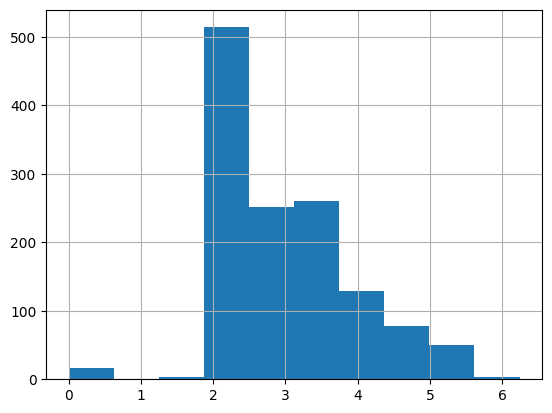

In [22]:
#normalize the fare values because it was not a normal distribution

all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

In [23]:
all_data[['Survived', 'train_test']].tail()

,Survived,train_test
413,NaN,0
414,NaN,0
415,NaN,0
416,NaN,0
417,NaN,0


In [24]:
#convert Passenger class to string data to be able to use get dummmies
all_data.Pclass = all_data.Pclass.astype(str)

In [25]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,cabin_multiple,cabin_adv,numeric_ticket,name_title,norm_fare
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,n,0,Mr,2.110213
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,C,0,Mrs,4.280593
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,n,0,Miss,2.188856
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,C,1,Mrs,3.990834
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,n,1,Mr,2.202765


In [26]:
#create dummy variables from all categorical variables
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'name_title', 'numeric_ticket', 'cabin_adv', 'cabin_multiple', 'Embarked', 'train_test']])

In [27]:
all_dummies

,Age,SibSp,Parch,norm_fare,numeric_ticket,cabin_multiple,train_test,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,name_title_Capt,name_title_Col,name_title_Don,name_title_Dona,name_title_Dr,name_title_Jonkheer,name_title_Lady,name_title_Major,name_title_Master,name_title_Miss,name_title_Mlle,name_title_Mme,name_title_Mr,name_title_Mrs,name_title_Ms,name_title_Rev,name_title_Sir,name_title_the Countess,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,2.110213,0,0,1,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
1,38.0,1,0,4.280593,0,1,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,26.0,0,0,2.188856,0,0,1,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,35.0,1,0,3.990834,1,1,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
4,35.0,0,0,2.202765,1,0,1,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,28.0,0,0,2.202765,0,0,0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
414,39.0,0,0,4.699571,0,1,0,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
415,38.5,0,0,2.110213,0,0,0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
416,28.0,0,0,2.202765,1,0,0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True


# Scale and split the data

In [28]:
#scale data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']] = scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])

In [29]:
all_dummies_scaled.head()

,Age,SibSp,Parch,norm_fare,numeric_ticket,cabin_multiple,train_test,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,name_title_Capt,name_title_Col,name_title_Don,name_title_Dona,name_title_Dr,name_title_Jonkheer,name_title_Lady,name_title_Major,name_title_Master,name_title_Miss,name_title_Mlle,name_title_Mme,name_title_Mr,name_title_Mrs,name_title_Ms,name_title_Rev,name_title_Sir,name_title_the Countess,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n,Embarked_C,Embarked_Q,Embarked_S
0,-0.580261,0.480272,-0.445407,-0.896331,0,0,1,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
1,0.662297,0.480272,-0.445407,1.347870,0,1,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,-0.269621,-0.479537,-0.445407,-0.815013,0,0,1,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,0.429318,0.480272,-0.445407,1.048255,1,1,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
4,0.429318,-0.479537,-0.445407,-0.800632,1,0,1,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True


In [30]:
#Isolate X and y train and test sets

from sklearn.model_selection import train_test_split

X_train = all_dummies_scaled[all_dummies_scaled['train_test'] == 1].drop(['train_test'], axis = 1)
y_train = all_data[all_data['train_test'] == 1].Survived
X_test = all_dummies_scaled[all_dummies_scaled['train_test'] == 0].drop(['train_test'], axis = 1)


In [31]:
y_train

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 889, dtype: float64

In [32]:
for x in [X_train, X_test, y_train]:
    print(len(x))


889
418
889


# **Modeling**

In [33]:
#Import packages for data modeling

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay 
from sklearn.metrics import silhouette_score #K-means
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn import naive_bayes
from sklearn import model_selection
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

import pickle

# 1. Logistic Regression

In [34]:
#instantiate the Logistic Regression
lr = LogisticRegression()

In [35]:
clf_lr = lr.fit(X_train, y_train)

In [36]:
clf_lr.coef_

array([[-0.39351044, -0.59941643, -0.33662052,  0.40249863,  0.00673201,
         0.04745735,  0.36183807,  0.243626  , -0.60531892,  0.94207441,
        -0.94192926, -0.22951973,  0.08849099, -0.42042104,  0.        ,
        -0.29248173, -0.14421555,  0.11226347, -0.01751017,  1.79980382,
        -0.13377683,  0.0639514 ,  0.02416296, -1.06511993,  0.57998   ,
         0.15588135, -0.92959552,  0.36625505,  0.04199662, -0.01675354,
         0.16960202, -0.27202915,  0.58469377,  0.9047114 ,  0.08603159,
        -0.58395227, -0.2631645 , -0.60899416,  0.15520333,  0.10148219,
        -0.25654037]])

In [37]:
clf_lr.intercept_

array([0.86079678])

In [38]:
y_pred_lr = clf_lr.predict(X_test)

In [39]:
lr_final_data = {'PassengerId': df_test.PassengerId, 'Survived': y_pred_lr}

In [40]:
lr_submit = pd.DataFrame(lr_final_data)
lr_submit

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


In [41]:
lr_submit.to_csv('Logistic_Regression_output.csv', index=False)

# 2. Decision Tree

In [42]:
dt = DecisionTreeClassifier(random_state=1)

In [43]:
clf_dt = dt.fit(X_train, y_train)

In [44]:
y_pred_dt = clf_dt.predict(X_test)

In [45]:
dt_final_data = {'PassengerId': df_test.PassengerId, 'Survived': y_pred_dt}

In [46]:
dt_submit = pd.DataFrame(dt_final_data)
dt_submit

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,1.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


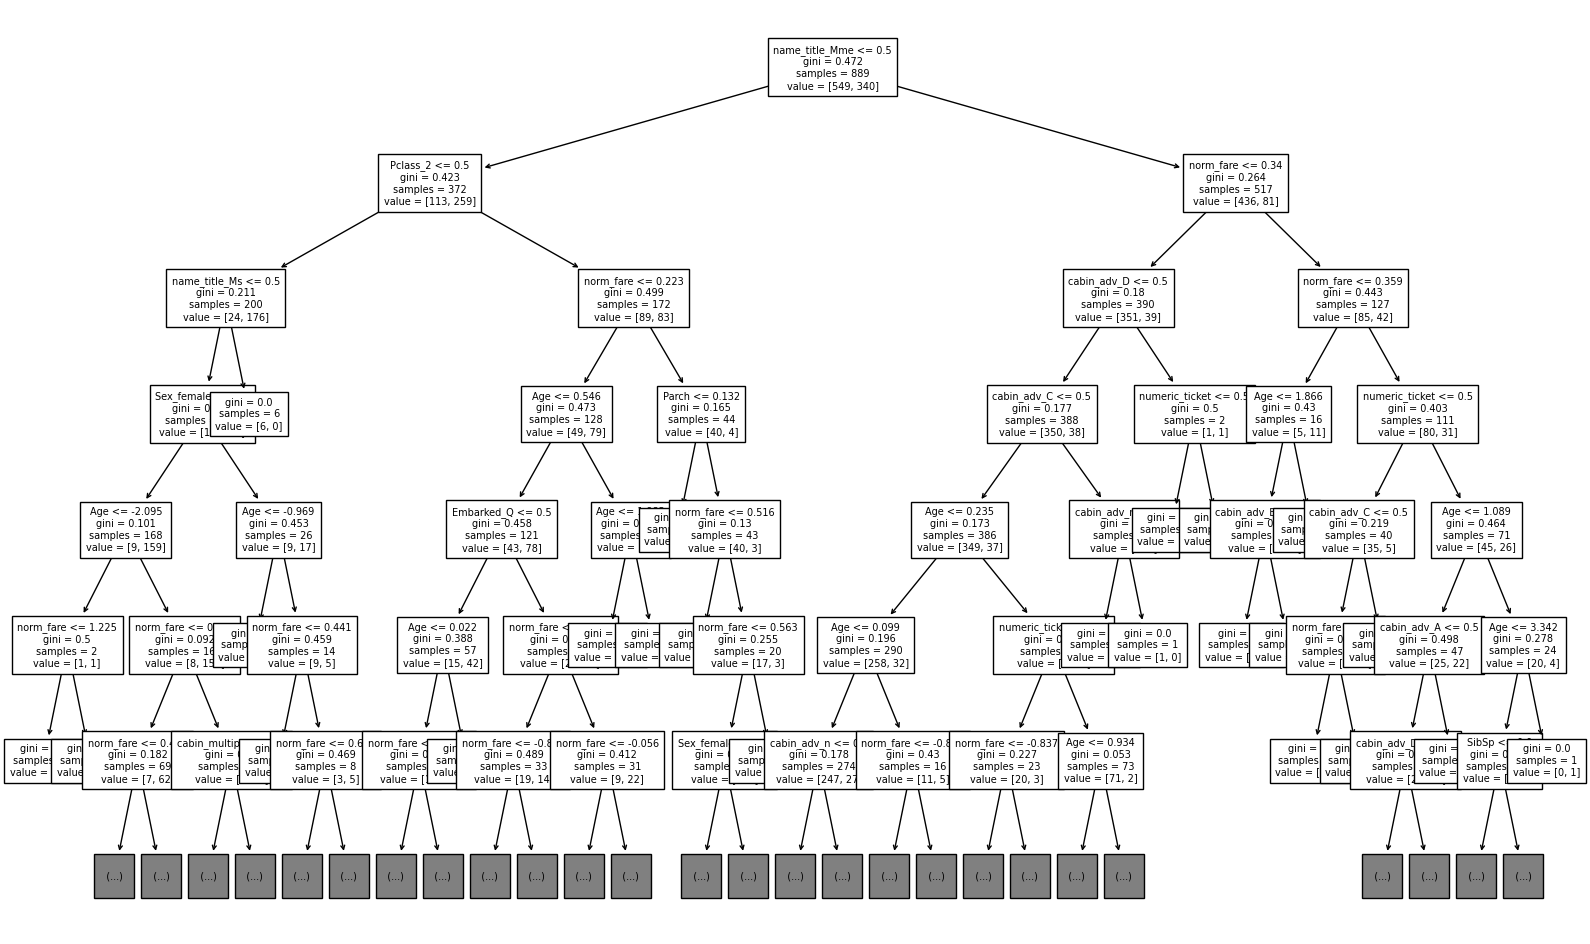

In [47]:
plt.figure(figsize=(20,12))
plot_tree(dt, max_depth = 6, fontsize=7, feature_names=all_dummies_scaled.columns);

In [48]:
dt_submit.to_csv('Decision_Tree_output.csv', index=False)

# 3. Naive Bayes

In [49]:
nb = naive_bayes.GaussianNB()

In [50]:
model_nb = nb.fit(X_train, y_train)

In [51]:
y_pred_nb = model_nb.predict(X_test)

In [52]:
nb_final_data = {'PassengerId': df_test.PassengerId, 'Survived': y_pred_nb}

In [53]:
nb_submit = pd.DataFrame(data=nb_final_data)
nb_submit

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


In [54]:
nb_submit.to_csv('Naive_Bayes_output.csv', index=False)

# 4. Random Forest

In [55]:
#instantiate the Random Forest Classifier

rf = RandomForestClassifier(random_state=1)

#Create a dictionary of hyperparameters to tune

param_grid = {'n_estimators': [100,400,800],
            'max_depth': [5,25,60,100,None],
            'max_features': ['sqrt', 10],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [1,2,6,10],
            'bootstrap': [True,False]}

In [56]:
# Save the grid search function for Random Forest
clf_rf = GridSearchCV(rf, param_grid, cv=3, verbose=1, n_jobs=-1)

In [57]:
# Fit the parameter tuning on your training data to get optimal parameters
fit_clf_rf = clf_rf.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


In [58]:
fit_clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 25,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 800}

In [59]:
fit_clf_rf.best_estimator_

RandomForestClassifier(max_depth=25, max_features=10, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=800, random_state=1)

In [60]:
best_rf = fit_clf_rf.best_estimator_

In [61]:
model_rf = best_rf.fit(X_train, y_train)

In [62]:
#Predict the test set using the trained model
y_pred_rf = model_rf.predict(X_test)

In [63]:
rf_final_data = {'PassengerId': df_test.PassengerId, 'Survived': y_pred_rf}

In [64]:
rf_submit = pd.DataFrame(data=rf_final_data)
rf_submit.to_csv('Random_Forest_Output.csv', index=False)

# 5. XGBoost

In [65]:
xgb = XGBClassifier(objective='binary:logistic', random_state=1)

In [66]:
param_grid_xgb = {'n_estimators': [100,400,700],
                 'colsample_bytree': [0.5,0.7],
                 'max_depth': [5,10,20],
                 'reg_alpha': [0.5,1],
                 'reg_lambda': [1,2],
                 'learning_rate': [0.4,0.7],
                 'gamma': [1,10],
                 'min_child_weight': [2,5,7]}

In [67]:
cv_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=3, verbose=1, n_jobs=-1)

In [68]:
fit_cv_xgb = cv_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


In [69]:
fit_cv_xgb.best_params_

{'colsample_bytree': 0.7,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 100,
 'reg_alpha': 0.5,
 'reg_lambda': 2}

In [70]:
fit_cv_xgb.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [71]:
best_xgb = fit_cv_xgb.best_estimator_

In [72]:
model_xgb = best_xgb.fit(X_train, y_train)

In [73]:
y_pred_xgb = model_xgb.predict(X_test)

In [74]:
xgb_final_data = {'PassengerId': df_test.PassengerId, 'Survived': y_pred_xgb}

In [75]:
submit_xgb = pd.DataFrame(xgb_final_data)

In [76]:
submit_xgb.to_csv('XGBoost_output.csv', index=False)